https://www.aavso.org/vsx/index.php?view=query.votable&ident=SX+Uma
This XML file does not appear to have any style information associated with it. The document tree is shown below.
<VOTABLE version="1.0">
<RESOURCE>
<DESCRIPTION>International Variable Star Index (VSX) Query Results</DESCRIPTION>
<TABLE>
<FIELD id="auid" name="AUID"/>
<FIELD id="name" name="Name"/>
<FIELD id="const" name="Const"/>
<FIELD id="radec2000" name="Coords(J2000)"/>
<FIELD id="varType" name="VarType"/>
<FIELD id="maxMag" name="MaxMag"/>
<FIELD id="maxPass" name="MaxMagPassband"/>
<FIELD id="minMag" name="MinMag"/>
<FIELD id="minPass" name="MinMagPassband"/>
<FIELD id="epoch" name="Epoch"/>
<FIELD id="novaYr" name="NovaYear"/>
<FIELD id="period" name="Period"/>
<FIELD id="riseDur" name="RiseDuration"/>
<FIELD id="specType" name="SpecType"/>
<FIELD id="disc" name="Discoverer"/>
<DATA>
<TABLEDATA>
<TR>
<TD>000-BDB-211</TD>
<TD>SX UMa</TD>
<TD>UMa</TD>
<TD>201.55608333,56.25697222</TD>
<TD>RRC</TD>
<TD>10.580</TD>
<TD>V</TD>
<TD>11.210</TD>
<TD>V</TD>
<TD>52746.48600</TD>
<TD/>
<TD>0.3071178</TD>
<TD>38</TD>
<TD>A4-F5</TD>
<TD>Sergei Belyavsky (1914)</TD>
</TR>
</TABLEDATA>
</DATA>
</TABLE>
</RESOURCE>
</VOTABLE>

In [38]:
from datetime import datetime
from timezonefinder import TimezoneFinder
from astropy.coordinates import EarthLocation
from astroplan import Observer
from geopy.geocoders import Nominatim
import pytz

def get_observer_and_local_time(city: str):
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.geocode(city, timeout=15)
    lat = location.latitude
    long = location.longitude

    # Get timezone
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=lat, lng=long)
    timezone = pytz.timezone(timezone_str)

    earth_location = EarthLocation(lat=lat, lon=long)
    observer = Observer(location=earth_location, name=city, timezone=timezone)

    # Get current local time at the location
    local_time = datetime.now(timezone)

    return observer, local_time

# Example usage:
observer, local_time = get_observer_and_local_time("van")
print(local_time)


2023-12-17 13:20:07.043613+03:00


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11092\1186763059.py:73: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


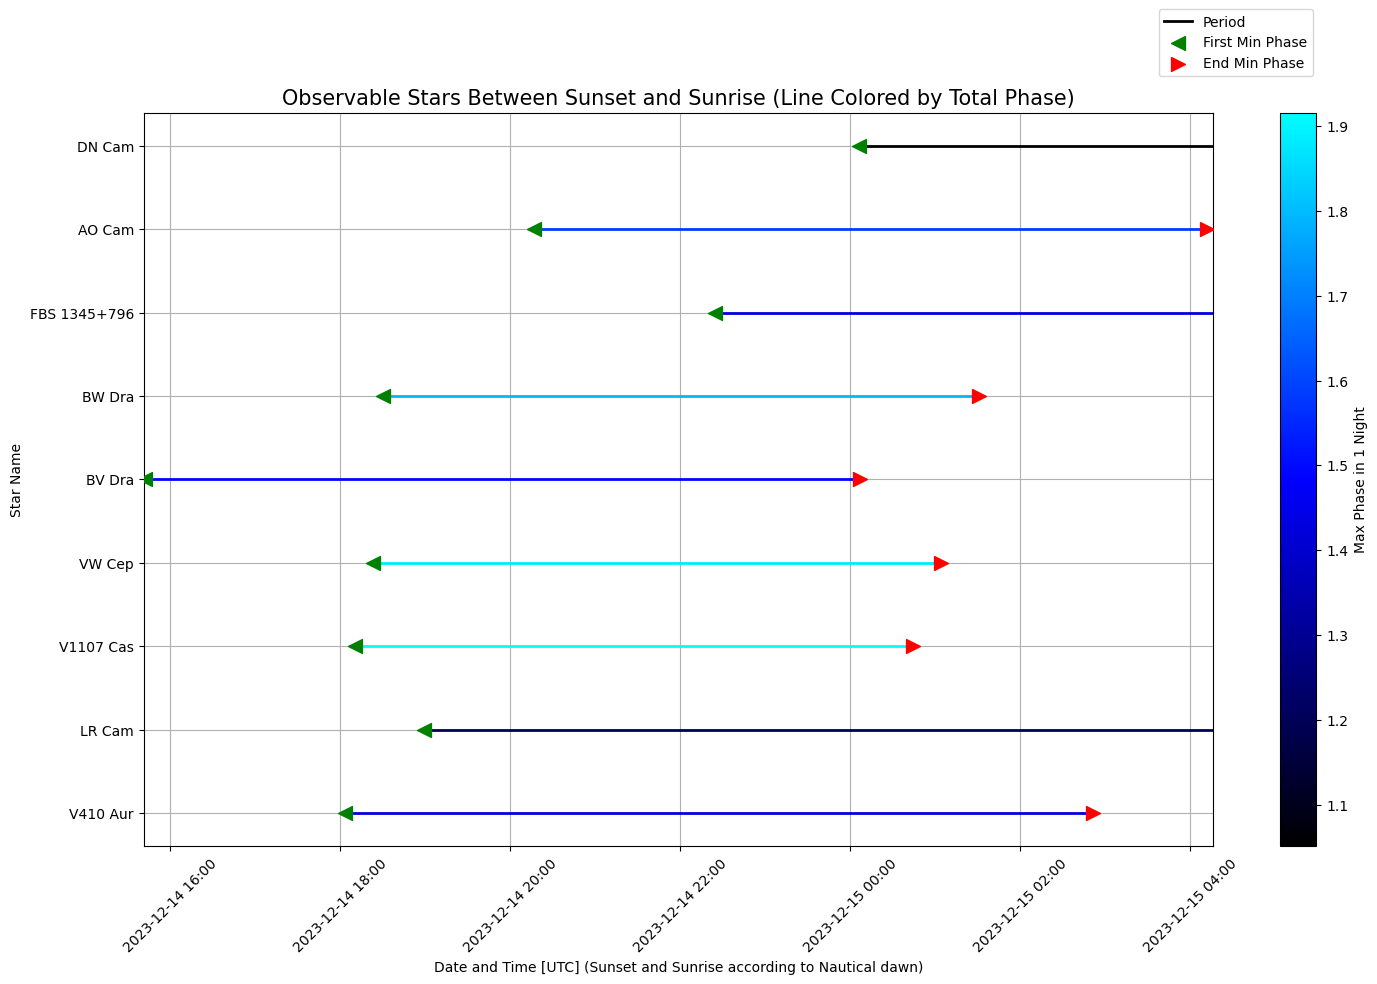

In [38]:
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 
import pandas as pd
import io

def generate_plot_and_return_buffer(data_path):
    # Reading in the data
    data = pd.read_csv(data_path)

    # Filter the data for stars that are observable and good for observation
    data['sunset_nautical_dawn'] = pd.to_datetime(data['sunset_nautical_dawn'])
    data['sunrise_nautical_dawn'] = pd.to_datetime(data['sunrise_nautical_dawn'])
    data['first_min_phase_date'] = pd.to_datetime(data['first_min_phase_date'])
    data['end_min_phase_date'] = pd.to_datetime(data['end_min_phase_date'])

    # Filter the data for stars that are observable and good for observation
    observable_stars = data[data['is_observable'] & data['good_for_observation']]

    # Setting up the plot with the specified requirements
    fig, ax = plt.subplots(figsize=(15, 10))
    observable_star_names = observable_stars['Star Name'].unique()
    y_values_observable = {name: i for i, name in enumerate(observable_star_names)}

    #A value is trying to be set on a copy of a slice from a DataFrame.
    pd.options.mode.chained_assignment = None 
    observable_stars.loc[:, 'y_value'] = observable_stars['Star Name'].map(y_values_observable)

    norm = Normalize(vmin=observable_stars['total_phase'].min(), vmax=observable_stars['total_phase'].max())
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["black", "blue", "cyan"])

    for _, row in observable_stars.iterrows():
        # Color for the line based on total_phase
        line_color = cmap(norm(row['total_phase']))

        # Draw line between the points
        line1,= ax.plot([row['first_min_phase_date'], row['end_min_phase_date']], [row['y_value'], row['y_value']], color=line_color, linewidth=2, zorder=2,label="Period")

        # Plot first and end min phase points
        line2 = ax.scatter(row['first_min_phase_date'], row['y_value'], color='green', s=100, marker="<", zorder=3, label="First Min Phase")  # First min phase
        if row['sunset_nautical_dawn'] <= row['end_min_phase_date'] <= row['sunrise_nautical_dawn']:
            line3 = ax.scatter(row['end_min_phase_date'], row['y_value'], color='red', s=100, marker=">", zorder=3, label="End Min Phase")  # End min phase

    # Set y-axis labels
    ax.set_yticks(ticks=range(len(observable_star_names)))
    ax.set_yticklabels(observable_star_names)

    # Set the x-axis limits
    min_sunset = observable_stars['sunset_nautical_dawn'].min()
    max_sunrise = observable_stars['sunrise_nautical_dawn'].max()

    ax.set_xlim(min_sunset, max_sunrise)

    # Format x-axis to display dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    ax.set_xlabel('Date and Time [UTC] (Sunset and Sunrise according to Nautical dawn)')
    ax.set_ylabel('Star Name')
    ax.set_title('Observable Stars Between Sunset and Sunrise (Line Colored by Total Phase)',fontsize=15)
    ax.grid(True)

    # Adding legends
    ax.legend(handles=[line1,line2,line3], loc='upper right', bbox_to_anchor=(1.1, 1.15))

    # Add a colorbar for total phase
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Max Phase in 1 Night')

    plt.tight_layout()

    # Save the plot to a bytes buffer
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    result_image = buffer.getvalue()
    observable_star_sunset_sunrise = io.BytesIO(result_image)
    return observable_star_sunset_sunrise

# Usage:
# Call the function with the path to your data CSV file
data_path = r"C:\Users\lenovo\Downloads\main_file (3).csv"
plot_buffer = generate_plot_and_return_buffer(data_path)


# You can now use the `plot_buffer` as needed, such as saving it to a file or sending it as a response.
plot_buffer

In [8]:

from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from dateutil import parser
from astropy import units as u

class DateCalculator:
    """
    A class for calculating Astropy Time and Heliocentric Julian Date.

    Attributes:
    - greenwich (EarthLocation): The Earth location for Greenwich.

    Methods:
    - calculate_astropy_time(date)
    - calculate_hjd(date, RA, DEC)
    """

    def __init__(self):
        """
        Initialize the DateCalculator.

        Attributes:
        - greenwich (EarthLocation): The Earth location for Greenwich.
        """
        self.greenwich = EarthLocation.of_site('greenwich')

    def calculate_astropy_time(self, date):
        """
        Calculate Astropy Time object from the given date.

        Args:
        - date (str): The date string.

        Returns:
        - astropy_date (Time): Astropy Time object.

        Usage:
        >>> astropy_time = DateCalculator.calculate_astropy_time('2023-01-01 12:00:00')
    
        """
        try:
            redate_object = parser.parse(date)
            date_str = redate_object.strftime("%Y-%m-%d %H:%M:%S")
            astropy_date = Time(date_str, format="iso", scale="utc", location=self.greenwich)
            return astropy_date
        except ValueError as e:
            raise ValueError(f"Error calculating Astropy Time: {str(e)}")

    def calculate_hjd(self, date, RA, DEC):
        """
        Calculate Heliocentric Julian Date (HJD) from the given date, right ascension, and declination.

        Args:
        - date (str): The date string.
        - RA (str): Right ascension.
        - DEC (str): Declination.

        Returns:
        - helio_jd (float): Heliocentric Julian Date.

        Usage:
        >>> hjd = DateCalculator().calculate_hjd('2023-01-01 12:00:00', '10h30m00s', '+45d00m00s')
        """
        try:
            astropy_date = self.calculate_astropy_time(date)
            ip_peg = SkyCoord(ra=RA, dec=DEC, unit=(u.deg, u.deg), frame='icrs')
            ltt_helio = astropy_date.light_travel_time(ip_peg, 'heliocentric')
            helio_jd = astropy_date.jd + ltt_helio.value
            return helio_jd
        except ValueError as e:
            raise ValueError(f"Error calculating HJD: {str(e)}")


In [9]:
DateCalculator().calculate_hjd(date='2023-01-01 12:00:00',RA='45.33072000',DEC='60.57229000')

2459946.0033681644

In [3]:
from astroquery.skyview import SkyView

def create_area_image(object_name: str, RA: float, DEC: float):
    """
    Creates an image of the area around a celestial object using astroquery.

    Args:
        object_name (str): The name of the celestial object.
        RA (float): The right ascension of the object in degrees.
        DEC (float): The declination of the object in degrees.
    
    Returns:
        PIL.Image.Image: An image containing the area around the celestial object.
    """
    size = 100  # Adjust the size of the field of view as needed
    survey = 'DSS'  # Select a survey, such as 'DSS', '2MASS', etc.

    images = SkyView.get_images(position=f"{RA}, {DEC}", survey=survey, pixels=500)
    
    if images:
        return images[0][0]
    else:
        return None

# Kullanım örneği
result_image = create_area_image("M1", 83.63308333, 22.0145)
if result_image:
    result_image.show  # Görseli görüntüle
else:
    print("Görüntü alınamadı.")


AttributeError: 'PrimaryHDU' object has no attribute 'show'

In [1]:
import requests
import json
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0",
    "Accept-Encoding": "*",
    "Connection": "keep-alive"
}
R = requests.post('http://nova.astrometry.net/api/login', data={'request-json': json.dumps({"apikey": "rffftoxwyfaymvpp"})},headers=headers)

print(R.text)

{"status": "success", "message": "authenticated user: esatakkasoglu@ogr.iu.edu.tr", "session": "2rqy5pz4x2eylvax3nmieba7mo8vb7pp"}


In [7]:
b = requests.post('http://nova.astrometry.net/api/url_upload', data={'request-json': json.dumps({"session": "2rqy5pz4x2eylvax3nmieba7mo8vb7pp", "url": "https://apod.nasa.gov/apod/image/2307/ChemicalFireball_Kleinburger_2774.jpg"})})

print(b.text)

{"status": "success", "subid": 8870008}


In [9]:
from PIL import Image
from io import BytesIO
c=requests.post(f'http://nova.astrometry.net/api/submissions/8870008')
print(c.text)

{"user": 46967, "processing_started": "2023-12-07 13:18:07.976497", "processing_finished": "2023-12-07 13:18:10.393917", "user_images": [9024032], "images": [19325752], "jobs": [9596598], "job_calibrations": []}


In [12]:

d=requests.post(f'http://nova.astrometry.net/api/jobs/9596598/info/')
print(d.text)
e=requests.post(f'http://nova.astrometry.net/api/jobs/9596598/calibration/')
print(e.text)
f=requests.post(f'http://nova.astrometry.net/annotated_display/9596598')
image_bytes = BytesIO(f.content)
print()
# PIL kütüphanesiyle görüntü olarak açma
img = Image.open(image_bytes)

# Görüntüyü gösterme veya işleme devam etme
img.show()

{"objects_in_field": ["2 Aqr)", "3 Aqr", "5 Cap)", "6 Aqr)", "6 Cap)", "71 Aql", "8 Cap)", "9 Cap)", "Al Shat (\u03bd Cap", "Albulaan (\u03bc Aqr", "Dabih Major (\u03b2 Cap", "Part of the constellation Capricornus (Cap)", "Secunda Giedi (\u03b12 Cap", "The star 69 Aql", "The star 70 Aql", "The star Albali (\u03b5 Aqr", "The star Albulan I", "The star Algedi", "The star Alshat", "The star Dabih", "The star Prima Giedi (\u03b11 Cap", "The star k Aqr", "The star l Aql", "\u03b21 Cap"], "machine_tags": ["Part of the constellation Capricornus (Cap)", "The star Dabih", "Dabih Major (\u03b2 Cap", "\u03b21 Cap", "9 Cap)", "The star Algedi", "Secunda Giedi (\u03b12 Cap", "6 Cap)", "The star Albali (\u03b5 Aqr", "2 Aqr)", "The star Prima Giedi (\u03b11 Cap", "5 Cap)", "The star l Aql", "71 Aql", "The star k Aqr", "3 Aqr", "The star Albulan I", "Albulaan (\u03bc Aqr", "6 Aqr)", "The star Alshat", "Al Shat (\u03bd Cap", "8 Cap)", "The star 69 Aql", "The star 70 Aql"], "tags": ["Part of the constel

In [10]:
import requests
import xml.etree.ElementTree as ET

def fetch_star_data(star_ident):
    """
    Fetch star data from AAVSO Variable Star Index (VSX).
    Parameters:
    - star_ident (str): The star identifier.
    Returns:
    - star_data (dict): The dict of star data.
    
    Usage:
    >>> result = fetch_star_data("v685 peg")
    {'auid': '000-BJH-115', 'name': 'V0685 Peg', 'const': 'Peg', 'ra2000': '358.33125000', 'dec2000': '28.39694444', 'varType': 'EW', 'maxMag': '11.680', 'maxPass': 'V', 'minMag': '12.400', 'minPass': 'V', 'epoch(HJD)': '2457700.6725', 'novaYr': None, 'period(d)': '0.3173', 'period(d:h:m)': '0d 7h 36m', 'riseDur(Perc)': None, 'riseDur(h)': None, 'specType': 'G7V', 'disc': None}

    """
    url = f"https://www.aavso.org/vsx/index.php?view=query.votable&ident={star_ident}"
    response = requests.get(url)

    if response.status_code != 200:
        return None

    root = ET.fromstring(response.content)
    star_data = []

    for star in root.findall(".//TR"):
        values = [star.find(f"./TD[{i}]").text for i in range(1, 16)]
        auid, name, const, ra_dec, varType, maxMag, maxPass, minMag, minPass, epoch, novaYr, period, riseDur, specType, disc = values
        #https://www.aavso.org/vsx/index.php?view=about.vartypes

        ra2000, dec2000 = ra_dec.split(",")[0], ra_dec.split(",")[1]

        period = float(period)
        days = int(period) if period >= 1 else 0
        hours = int((period - days) * 24)
        minutes = int(((period - days) * 24 - hours) * 60)
        #This parameter contains either the rise time (M-m) for intrinsic variables, or the duration of the eclipse (D) for eclipsing binaries, both given as a percentage of the period value for the star. These values help to define the shape of the light curve.
        riseDur_hours = f"{((float(riseDur) / 100) * period) * 24:.3f}" if riseDur else None

        star_info = {
            "auid": auid, "name": name, "const": const, "ra2000": ra2000,
            "dec2000": dec2000, "varType": varType, "maxMag": maxMag, "maxPass": maxPass,
            "minMag": minMag, "minPass": minPass, "epoch(HJD)": f"{2400000 + float(epoch)}",
            "novaYr": novaYr, "period(d)": f"{period:.4f}", "period(d:h:m)": f"{days}d {hours}h {minutes}m",
            "riseDur(Perc)": riseDur, "riseDur(h)": riseDur_hours, "specType": specType, "disc": disc
        }
        star_data.append(star_info)

    return star_data

# To use the function:
star_ident = "V685 Peg "
result = fetch_star_data(star_ident)
if result:
    print(result[0])
    for star_info in result:
        print(((2460601.92 - 2460201.28) * 50.08))
else:
    print("Sayfa bulunamadı veya başka bir hata oluştu.")


{'auid': '000-BJH-115', 'name': 'V0685 Peg', 'const': 'Peg', 'ra2000': '358.33125000', 'dec2000': '28.39694444', 'varType': 'EW', 'maxMag': '11.680', 'maxPass': 'V', 'minMag': '12.400', 'minPass': 'V', 'epoch(HJD)': '2457700.6725', 'novaYr': None, 'period(d)': '0.3173', 'period(d:h:m)': '0d 7h 36m', 'riseDur(Perc)': None, 'riseDur(h)': None, 'specType': 'G7V', 'disc': None}
20064.05120000653


In [8]:
from astropy.time import Time
import astropy.units as u
from astroplan import EclipsingSystem

primary_eclipse_time = Time(2452826.628514, format='jd')
orbital_period = 3.52474859 * u.day
eclipse_duration = 0.1277 * u.day

hd209458 = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                           orbital_period=orbital_period, duration=eclipse_duration,
                           name='HD 209458 b')

print(hd209458)

In [166]:
from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra="00h42m30s", dec='+41d12m00s', unit=(u.hourangle, u.deg), frame='icrs')
c  

<SkyCoord (ICRS): (ra, dec) in deg
    (10.625, 41.2)>

In [11]:
import requests
import xml.etree.ElementTree as ET
from io import BytesIO
from PIL import Image

def chart_info(star:str, fov:float=14, mag_limit:float=15.5, north:str="up", east:str="left", other:str="gcvs", dss:bool=False, bands_limit:int=2):
    """
    Fetch chart information from AAVSO Variable Star Plotter (VSP).
    Parameters:
    - star (str): The star name.
    - fov (float): The field of view. Default:``14``
    - mag_limit (float): The magnitude limit. Default:``15.5``
    - north (str): The north direction. ``'up'``(Default) or ``'down'``
    - east (str): The east direction. ``'left'``(Default) or ``'right'``
    - other (str): The other stars. ``'gcvs'``(Default) or ``'all'``
    - dss (bool): The DSS(Digitized Sky Survey) image. ``False``(Default) or ``True``
    - bands_limit (int): The bands limit. Default:``2``
    Returns:
    - chart_info (dict): The dict of chart(area of the star) information.

    Usage:
    >>> result = chart_info(star="SS Cyg", mag_limit=20.0)
    >>> print(result)
    {'main_url': 'https://app.aavso.org/vsp/api/chart/?star=SS+Cyg&fov=14&maglimit=20.0&north=up&east=left&other=gcvs&dss=False&format=xml', 'Chart_ID': '000-BJH-115', 'Image_Link': 'https://www.aavso.org/apps/vsp/chart/000-BJH-115.png', 'Star': 'V0685 Peg', 'FOV': '14', 'Mag_Limit': '20.0', 'Table_Data': [{'Auid': '000-BJH-115', 'Ra': '358.33125000', 'Dec': '28.39694444', 'Label': 'V0685 Peg', 'Comments': 'V0685 Peg', 'Bands': 'V: 11.680 (0.030), B: 12.400 (0.030)'}], 'Area_Image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x800 at 0x7F3D6E9E4E10>}

    """
    star = star.replace(" ", "+")
    url = f"https://app.aavso.org/vsp/api/chart/?star={star}&fov={fov}&maglimit={mag_limit}&north={north}&east={east}&other={other}&dss={dss}&format=xml"

    response = requests.get(url)
    if response.status_code != 200:
        return None

    root = ET.fromstring(response.text)
    chart_id, star_name, field_of_view, mag_limit_value, image_link = (root.find(field).text for field in ["chartid", "star", "fov", "maglimit", "image_uri"])

    table_data = []
    photometry_data = root.find("photometry")
    if photometry_data is not None:
        for list_item in photometry_data.findall("list-item"):
            data = {field.tag.capitalize(): field.text for field in list_item if field.tag in ["auid", "ra", "dec", "label", "comments"]}
            data["Bands"] = ", ".join(f"{band.find('band').text}: {band.find('mag').text} ({band.find('error').text})" for band in list_item.find("bands").findall("list-item")[:bands_limit])
            table_data.append(data)

    area_image = None
    response_image = requests.get(image_link)
    if response_image.status_code == 200:
        area_image = Image.open(BytesIO(response_image.content))

    return {
        "main_url": url,
        "Chart_ID": chart_id,
        "Image_Link": image_link,
        "Star": star_name,
        "FOV": field_of_view,
        "Mag_Limit": mag_limit_value,
        "Table_Data": table_data,
        "Area_Image": area_image
    }

# Usage of the function and retrieving the output
output = chart_info(star="V685 Peg ", mag_limit=20.0,dss=True)
print(output)


{'main_url': 'https://app.aavso.org/vsp/api/chart/?star=V685+Peg+&fov=14&maglimit=20.0&north=up&east=left&other=gcvs&dss=True&format=xml', 'Chart_ID': 'X35373KAY', 'Image_Link': 'https://app.aavso.org/vsp/chart/X35373KAY.png?format=xml', 'Star': 'V685 Peg ', 'FOV': '14.0', 'Mag_Limit': '20.0', 'Table_Data': [], 'Area_Image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1230x1530 at 0x17F11EF48D0>}


In [7]:
output['Area_Image'].show()

In [4]:
from pprint import pprint 
pprint(output,sort_dicts=False)

{'main_url': 'https://app.aavso.org/vsp/api/chart/?star=SS+Cyg&fov=14&maglimit=20.0&north=up&east=left&other=gcvs&dss=False&format=xml',
 'Chart_ID': 'X35238BN',
 'Image_Link': 'https://app.aavso.org/vsp/chart/X35238BN.png?format=xml',
 'Star': 'SS Cyg',
 'FOV': '14.0',
 'Mag_Limit': '20.0',
 'Table_Data': [{'Auid': '000-BCP-235',
                 'Ra': '21:43:08.69',
                 'Dec': '43:35:00.6',
                 'Label': '86',
                 'Comments': None,
                 'Bands': 'V: 8.556 (0.084), U: 11.153 (0.113)'},
                {'Auid': '000-BCP-198',
                 'Ra': '21:42:20.24',
                 'Dec': '43:34:03.3',
                 'Label': '98',
                 'Comments': None,
                 'Bands': 'V: 9.794 (0.071), U: 10.4 (0.082)'},
                {'Auid': '000-BCP-202',
                 'Ra': '21:42:27.17',
                 'Dec': '43:33:44.6',
                 'Label': '109',
                 'Comments': None,
                 'Bands': '